In [67]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import cv2
import os

In [68]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = cv2.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [69]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [70]:
human_parsing = load_images_from_folder('Task/dataset/human_parsing')
image = load_images_from_folder('Task/dataset/image')
pose_img = load_images_from_folder('Task/dataset/pose_img')
pose_json = load_jsons_from_folder('Task/dataset/pose_json')

100%|██████████| 704/704 [00:02<00:00, 348.24it/s]


In [71]:
len(human_parsing)

2

In [72]:
# assert all(human_parsing[1] == image[1] == pose_img[1])
df_names = pd.DataFrame()
df_names['human_parsing'] = human_parsing[1]
df_names['image'] = image[1]
df_names['pose_img'] = pose_img[1]
df_names['pose_json'] = pose_json[1]

In [73]:
df_names

,human_parsing,image,pose_img,pose_json
0,168762_00.png,168762_00.jpg,168762_00_rendered.png,168762_00_keypoints.json
1,168764_00.png,168764_00.jpg,168764_00_rendered.png,168764_00_keypoints.json
2,168784_00.png,168784_00.jpg,168784_00_rendered.png,168784_00_keypoints.json
3,168810_00.png,168810_00.jpg,168810_00_rendered.png,168810_00_keypoints.json
4,168829_00.png,168829_00.jpg,168829_00_rendered.png,168829_00_keypoints.json
...,...,...,...,...
699,80936_00.png,80936_00.jpg,80936_00_rendered.png,80936_00_keypoints.json
700,80941_00.png,80941_00.jpg,80941_00_rendered.png,80941_00_keypoints.json
701,80948_00.png,80948_00.jpg,80948_00_rendered.png,80948_00_keypoints.json
702,80959_00.png,80959_00.jpg,80959_00_rendered.png,80959_00_keypoints.json


In [74]:
df = pd.DataFrame()
df['human_parsing'] = human_parsing[0]
df['image'] = image[0]
df['pose_img'] = pose_img[0]
df['pose_json'] = pose_json[0]

In [75]:
# #show the first image
# df.head(1)

In [84]:
#show 3 images inline
def show_images(df, index):
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(df['human_parsing'][index])
    plt.subplot(132)
    plt.imshow(df['image'][index])
    plt.subplot(133)
    plt.imshow(df['pose_img'][index])

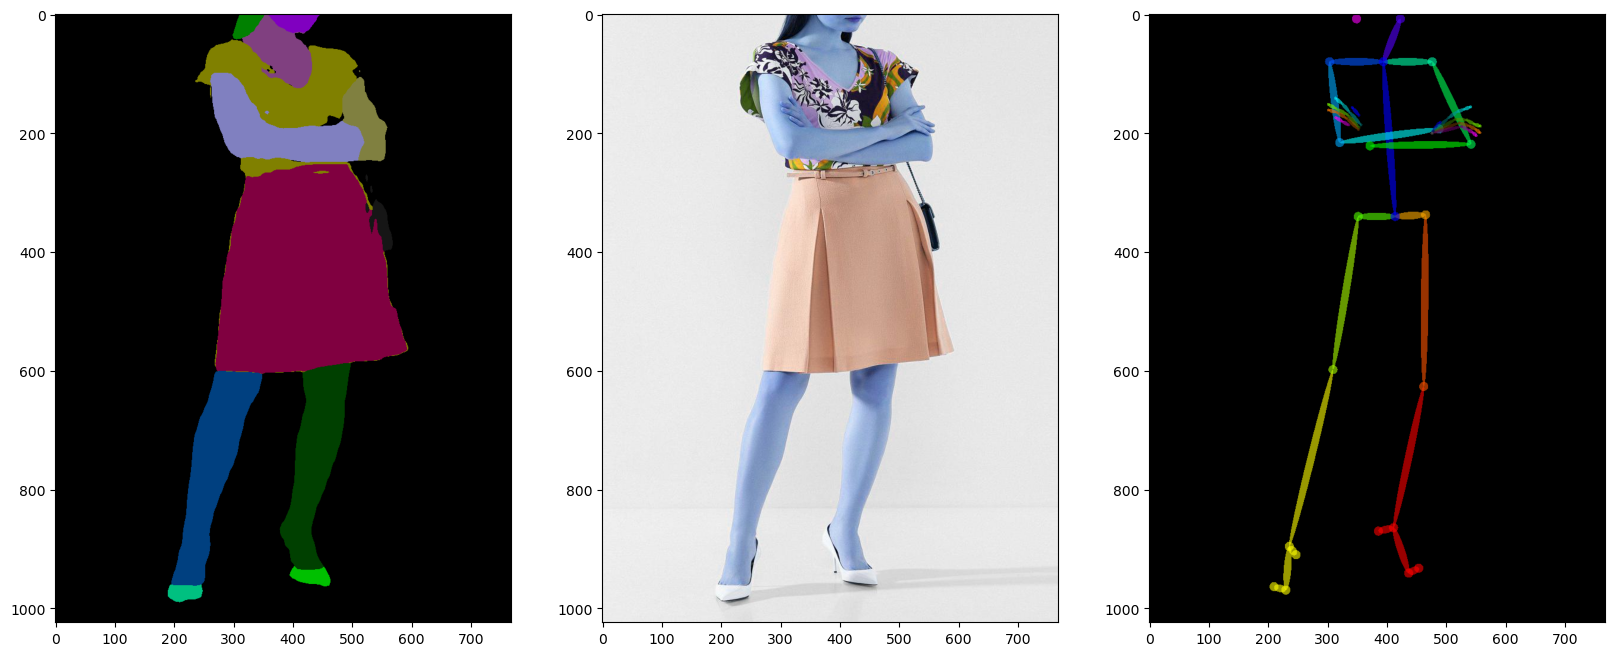

In [85]:
show_images(df,0)